## Creating a composite image from multiple PlanetScope scenes


In this exercise, you'll learn how to create a composite image (or mosaic) from multiple PlanetScope satellite images that cover an area of interest (AOI). We'll use `rasterio`, along with its vector-data counterpart `fiona`, to do this. 

### Step 1. Aquiring Imagery

In order to visually search for imagery in our AOI, we'll use [Planet Explorer](https://www.planet.com/explorer/).

For this exercise, we're going to visit Yosemite National Park. In the screenshot below you'll see an AOI drawn around [Mount Dana](https://en.wikipedia.org/wiki/Mount_Dana) on the eastern border of Yosemite. You can use [data/mt-dana-small.geojson](data/mt-dana-small.geojson) to search for this same AOI yourself.

Here we want an image that depicts the mountain on a clear summer day, so for this data search in Planet Explorer we'll set the filters to show only scenes with less than 5% cloud cover, and narrow down the date range to images captured between July 1-July 31, 2017. Since we're only interested in PlanetScope data, and we're creating a visual - not analytic - product, we'll set the Source to `3-band PlanetScope Scene`. Finally, since we want to create a mosaic that includes our entire AOI, we'll set the Area coverage to full coverage.

![Mount Dana in Planet Explorer](images/explorer-mount-dana.gif)

As you can see in the animated gif above, this search yields multiple days within July 2017 that match our filters. After previewing a few days, I decided I like the look of July 21, 2017.

After selecting a single day, you can roll over the individual images to preview their coverage. In the gif above, you'll notice that it takes three individual images to completely cover our AOI. In this instance, as I roll over each item in Planet Explorer I can see that the scenes' rectangular footprints extend far beyond Mount Dana. All three scenes overlap slightly, and one scene touches only a small section at the bottom of the AOI. Still, taken together the images provide 100% coverage, so we'll go ahead and place an order for the Visual imagery products for these three scenes.

#### ![Download imagery Planet Explorer](images/explorer-data-order.png)

Once the order is ready, download the images, extract them from the .zip, and move them into the `data/` directory adjacent to this Notebook.

### Step 2. Inspecting Imagery

In [1]:
# Load our 3 images using rasterio

import rasterio

img1 = rasterio.open('data/20170721_175836_103c_3B_Visual.tif')
img2 = rasterio.open('data/20170721_175837_103c_3B_Visual.tif')
img3 = rasterio.open('data/20170721_175838_103c_3B_Visual.tif')

At this point we can use `rasterio` to inspect the metadata of these three images. Specifically, in order to create a composite from these images, we want to verify that all three images have the same data type, the same coordinate reference systems and the same band count:

In [2]:
print(img1.meta['dtype'], img1.meta['crs'], img1.meta['count'])
print(img2.meta['dtype'], img2.meta['crs'], img2.meta['count'])
print(img3.meta['dtype'], img3.meta['crs'], img3.meta['count'])

uint8 EPSG:32611 4
uint8 EPSG:32611 4
uint8 EPSG:32611 4


Success - they do! But wait, I thought we were using a "Visual" image, and expecting only 3 bands of information (RGB)?

Let's take a closer look at what these bands contain:

In [3]:
# Read in color interpretations of each band in img1 - here we'll assume img2 and img3 have the same values
colors = [img1.colorinterp[band] for band in range(img1.count)]

# take a look at img1's band types:
for color in colors:
    print(color.name)

red
green
blue
alpha


The fourth channel is actually a binary alpha mask: this is common in satellite color models, and can be confirmed in Planet's [documentation on the PSSCene3Band product](https://developers.planet.com/docs/api/psscene3band/).

Now that we've verified all three satellite images have the same critical metadata, we can safely use `rasterio.merge` to stitch them together.

### Step 3. Creating the Mosaic

In [4]:
from rasterio.merge import merge

# merge returns the mosaic & coordinate transformation information
(mosaic, transform) = merge([img1, img2, img3])

Once that process is complete, take a moment to congratulate yourself. At this stage you've successfully acquired adjacent imagery, inspected metadata, and performed a compositing process in order to generate a new mosaic. Well done!

Before we go further, let's use `rasterio.plot` (a matplotlib interface) to preview the results of our mosaic. This will just give us a quick-and-dirty visual representation of the results, but it can be useful to verify the compositing did what we expected.

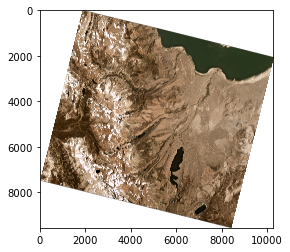

<AxesSubplot:>

In [5]:
from rasterio.plot import show

show(mosaic)

At this point we're ready to write our mosaic out to a new GeoTIFF file. To do this, we'll want to grab the geospatial metadata from one of our original images (again, here we'll use img1 to represent the metadata of all 3 input images).

In [6]:
# Grab a copy of our source metadata, using img1
meta = img1.meta

# Update the original metadata to reflect the specifics of our new mosaic
meta.update({"transform": transform,
    "height":mosaic.shape[1],
    "width":mosaic.shape[2]})

with rasterio.open('data/mosaic.tif', 'w', **meta) as dst:
    dst.write(mosaic)

### Step 4. Clip the Mosaic to AOI Boundaries

Now that we've successfully created a composite mosaic of three input images, the final step is to clip that mosaic to our area of interest. To do that, we'll create a mask for our mosaic based on the AOI boundaries, and crop the mosaic to the extents of that mask.

You'll recall that we used Explorer to search for Mount Dana, in Yosemite National Park. The GeoJSON file we used for that search can also be used here, to provide a mask outline for our mosaic.

For this step we're going to do a couple things: first, we'll use rasterio's sister-library `fiona` to read in the GeoJSON file. Just as `rasterio` is used to manipulate raster data, `fiona` works similarly on vector data. Where `rasterio` represents raster imagery as numpy arrays, `fiona` represents vector data as GeoJSON-like Python dicts. You can learn [more about fiona here](http://toblerity.org/fiona/manual.html).

After reading in the GeoJSON you'll want to extract the _geometry_ of the AOI (_hint:_ `geometry` will be the dict key). 

#### A note about Coordinate Reference Systems

If you attempt to apply the AOI to the mosaic imagery now, rasterio will throw errors, telling you that the two datasets do not overlap. This is because the Coordinate Reference System (CRS) used by each dataset do not match. You can verify this by reading the `crs` attribute of the Collection object generated by `fiona.open()`.

_Hint: the CRS of mt-dana-small.geojson is:_  `'epsg:4326'`

You'll recall that earlier we validated the metadata of the original input imagery, and learned it had a CRS of `'epsg:32611'`. 

Before the clip can be applied, you will need to to transform the geometry of the AOI to match the CRS of the imagery. Luckily, fiona is smart enough to apply the necessary mathematical transformation to a set of coordinates in order to convert them to new values: apply `fiona.transform.transform_geom` to the AOI geometry to do this, specifying the GeoJSON's CRS as the source CRS, and the imagery's CRS as the destination CRS.

In [7]:
# use rasterio's sister-library for working with vector data
import fiona

# use fiona to open our original AOI GeoJSON
with fiona.open('data/mt-dana-small.geojson') as mt:
    aoi = [feature["geometry"] for feature in mt]
    
# transform AOI to match mosaic CRS
from fiona.transform import transform_geom
transformed_coords = transform_geom('EPSG:4326', 'EPSG:32611', aoi[0])

aoi = [transformed_coords]

At this stage you have read in the AOI geometry and transformed its coordinates to match the mosaic. We're now ready to use `rasterio.mask.mask` to create a mask over our mosaic, using the AOI geometry as the mask line. 

Passing `crop=True` to the mask function will automatically crop the bits of our mosaic that fall outside the mask boundary: you can think of it as applying the AOI as a cookie cutter to the mosaic.

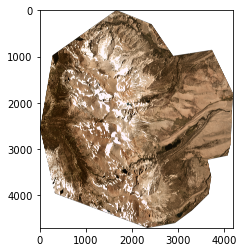

<AxesSubplot:>

In [8]:
# import rasterio's mask tool
from rasterio.mask import mask

# apply mask with crop=True to cut to boundary
with rasterio.open('data/mosaic.tif') as mosaic:
    clipped, transform = mask(mosaic, aoi, crop=True)
    
# See the results!
show(clipped)

Congratulations! You've created a clipped mosaic, showing only the imagery that falls within our area of interest.

From here, the only thing left to do is save our results to a final output GeoTIFF.

In [9]:
# save the output to a final GeoTIFF

# use the metadata from our original mosaic
meta = mosaic.meta.copy()

# update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# write the output to a GeoTIFF
with rasterio.open('data/clipped_mosaic.tif', 'w', **meta) as dst:
    dst.write(clipped)


### Final results

If you like, you might take a closer look at the final clipped mosaic using QGIS:

![Final clipped mosaic viewed in QGIS](images/final_in_qgis.png)